# Wind ANN - Seasonal

### Load and preprocess data

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

data = pd.read_csv('../../AutoCombine.csv')
data = data.fillna(0)
data['BeginDate'] = pd.to_datetime(data['BeginDate']).dt.tz_localize(None)

/var/folders/bl/pt11zfbj2bd16s363ftmwj_h0000gn/T/ipykernel_6252/2149622158.py:6: DtypeWarning: Columns (12,17) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../../AutoCombine.csv')


In [13]:
# find the latest date in dateset
latest_date = data['BeginDate'].max()

# Get the month from the latest date
latest_month = latest_date.month

# determine season
if latest_month in (12, 1, 2):
    # winter
    season_months = [12, 1, 2]
elif latest_month in (3, 4, 5):
    # Spring
    season_months = [3, 4, 5]
elif latest_month in (6, 7, 8):
    # Summer
    season_months = [6, 7, 8]
else:
    # Fall
    season_months = [9, 10, 11]

# filter data for the season based on latest date
data = data[data['BeginDate'].dt.month.isin(season_months)]

In [14]:
data["Sum"] = data[["Coal", "Hydro", "Natural Gas", "Nuclear", "Oil", 
                    "Other", "Landfill Gas", "Refuse", "Solar", "Wind", "Wood"]].sum(axis=1)

data['Previous_Day'] = data['BeginDate'] - pd.Timedelta(days=1)
data['Previous_Year'] = data['BeginDate'] - pd.DateOffset(years=1)

In [15]:
# Calculate the average of 'Sum' for the latest month
# Filter the data to include only the rows from the latest month
latest_month_data = data[data['BeginDate'].dt.month == latest_month]

# Calculate the average of the 'Sum' column for the latest month
average_sum_latest_month = latest_month_data['Sum'].mean()
print(f"The average sum for the latest month ({latest_date.strftime('%Y-%m')}) is: {average_sum_latest_month}")

monthly_avg_sum = data.groupby(data['BeginDate'].dt.to_period("M"))['Sum'].mean()
# Display the average sum for each month
print(monthly_avg_sum)

latest_date = data['BeginDate'].max()
latest_month_period = latest_date.to_period("M")

# Get the average sum for the latest month
latest_month_avg_sum = monthly_avg_sum[latest_month_period]

# Calculate the scaling factor for each month
scaling_factors = latest_month_avg_sum / monthly_avg_sum

# Map the scaling factors back to the original dates in the dataframe
data['ScalingFactor'] = data['BeginDate'].dt.to_period("M").map(scaling_factors)

# Apply the scaling factors to each 'Sum' entry
data['AdjustedSum'] = data['Sum'] * data['ScalingFactor']
data['AdjustedWind'] = data['Wind'] * data['ScalingFactor']

wind_data = data[['BeginDate', 'AdjustedWind','Previous_Day','Previous_Year']].copy()

The average sum for the latest month (2025-02) is: 11120.124865556978
BeginDate
2021-12    10884.893254
2022-01    12109.617641
2022-02    11208.623425
2022-12    11345.796365
2023-01    11001.740688
2023-02    11156.062208
2023-12    11000.186551
2024-01    11952.686172
2024-02    10988.178832
2024-12    11586.524135
2025-01    11865.590197
2025-02    11268.327933
Freq: M, Name: Sum, dtype: float64


In [16]:
from bisect import bisect_left

def get_previous_day_Wind(row, reference_df):
    # sort
    sorted_dates = reference_df['BeginDate'].values
    wind_values = reference_df['AdjustedWind'].values

    # binary search to find index of closest date
    target_date = row['Previous_Day']
    pos = bisect_left(sorted_dates, target_date)

    # find the closest date and return corresponding wind values
    if pos == 0:
        return wind_values[0]
    if pos == len(sorted_dates):
        return wind_values[-1]
    
    before = sorted_dates[pos - 1]
    after = sorted_dates[pos]

    # return the wind value that corresponds to the closest date
    if abs(target_date - before) <= abs(target_date - after):
        return wind_values[pos - 1]
    else:
        return wind_values[pos]

In [17]:
from bisect import bisect_left

def get_two_days_before_Wind(row, reference_df):
    # Sort reference_df by 'BeginDate' for fast lookups
    sorted_dates = reference_df['BeginDate'].values
    wind_values = reference_df['AdjustedWind'].values
    
    # Calculate two days before
    target_date = row['BeginDate'] - pd.Timedelta(days=2)
    
    # Perform binary search to find the index of the closest date
    pos = bisect_left(sorted_dates, target_date)
    
    # Find the closest date and return corresponding wind value
    if pos == 0:
        return wind_values[0]
    if pos == len(sorted_dates):
        return wind_values[-1]
    
    before = sorted_dates[pos - 1]
    after = sorted_dates[pos]
    
    # Return the wind value corresponding to the closest date
    if abs(target_date - before) <= abs(target_date - after):
        return wind_values[pos - 1]
    else:
        return wind_values[pos]

In [18]:
from bisect import bisect_left

def get_previous_year_Wind(row, reference_df):
    # Sort reference_df by 'BeginDate' for fast lookups
    sorted_dates = reference_df['BeginDate'].values
    wind_values = reference_df['AdjustedWind'].values
    
    # Perform binary search to find the index of the closest date
    target_date = row['Previous_Year']
    pos = bisect_left(sorted_dates, target_date)
    
    # Find the closest date and return corresponding wind value
    if pos == 0:
        return wind_values[0]
    if pos == len(sorted_dates):
        return wind_values[-1]
    
    before = sorted_dates[pos - 1]
    after = sorted_dates[pos]
    
    # Return the wind value corresponding to the closest date
    if abs(target_date - before) <= abs(target_date - after):
        return wind_values[pos - 1]
    else:
        return wind_values[pos]


In [19]:
data['Previous_Year_Wind'] = data.apply(get_previous_year_Wind, axis=1, reference_df=wind_data)

In [20]:
cutoff_date = pd.to_datetime("2021-10-01").tz_localize(None)
usable_data = data[data['BeginDate'] > cutoff_date].copy()
wind_data2 = usable_data[['BeginDate', 
                          'Wind', 
                          'Previous_Day',
                          'Previous_Year']].copy()

In [ ]:
usable_data['Previous_Day_Wind'] = usable_data.apply(get_previous_day_Wind, axis=1, reference_df=wind_data)
usable_data['Previous_2Day_Wind'] = usable_data.apply(get_two_days_before_Wind, axis=1, reference_df=wind_data)


In [22]:
usable_data['Hour_of_Day'] = usable_data['BeginDate'].dt.hour
usable_data['Month'] = usable_data['BeginDate'].dt.month
usable_data['Year'] = usable_data['BeginDate'].dt.year
features = usable_data[['Month','Year','Previous_Year_Wind','Previous_2Day_Wind','AdjustedSum','temp', 'humidity', 'precip', 'uvindex', 'cloudcover', 'solarradiation','Previous_Day_Wind','solarenergy','Hour_of_Day','dew','dew','snow','snowdepth','windspeed','windgust', 'winddir']]

# Useless Features , 'winddir',,
target = usable_data['Wind']

print("Features shape: ", features.shape)
print('Target shape: ', target.shape)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

Features shape:  (71818, 21)
Target shape:  (71818,)


In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=70,
                               restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss',
                                facotr=0.5,
                                patience=10, 
                                min_le=1e-6)

In [24]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LeakyReLU

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, 
                          kernel_regularizer=regularizers.l2(0.001), 
                          input_shape=(X_train.shape[1],)),
    LeakyReLU(alpha=0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, kernel_regularizer=regularizers.l2(0.01)),
    LeakyReLU(alpha=0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, kernel_regularizer=regularizers.l2(0.001)),
    # tf.keras.layers.Dropout(0.5), 
    LeakyReLU(alpha=0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_absolute_error')

history = model.fit(X_train, 
                    y_train, 
                    epochs=500, 
                    validation_split=0.2, 
                    batch_size=128, 
                    callbacks=[early_stopping, lr_scheduler])

test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')



Epoch 1/500
360/360 [==============================] - 4s 4ms/step - loss: 491.7426 - val_loss: 477.3273 - lr: 0.0010
Epoch 2/500
360/360 [==============================] - 1s 3ms/step - loss: 469.4244 - val_loss: 440.9466 - lr: 0.0010
Epoch 3/500
360/360 [==============================] - 1s 3ms/step - loss: 427.7713 - val_loss: 388.9091 - lr: 0.0010
Epoch 4/500
360/360 [==============================] - 1s 3ms/step - loss: 370.4378 - val_loss: 332.4501 - lr: 0.0010
Epoch 5/500
360/360 [==============================] - 1s 3ms/step - loss: 303.5317 - val_loss: 267.7361 - lr: 0.0010
Epoch 6/500
360/360 [==============================] - 1s 3ms/step - loss: 236.4573 - val_loss: 185.1766 - lr: 0.0010
Epoch 7/500
360/360 [==============================] - 1s 3ms/step - loss: 182.4305 - val_loss: 156.5429 - lr: 0.0010
Epoch 8/500
360/360 [==============================] - 1s 3ms/step - loss: 150.6480 - val_loss: 129.1549 - lr: 0.0010
Epoch 9/500
360/360 [==============================] - 1

### Analysis

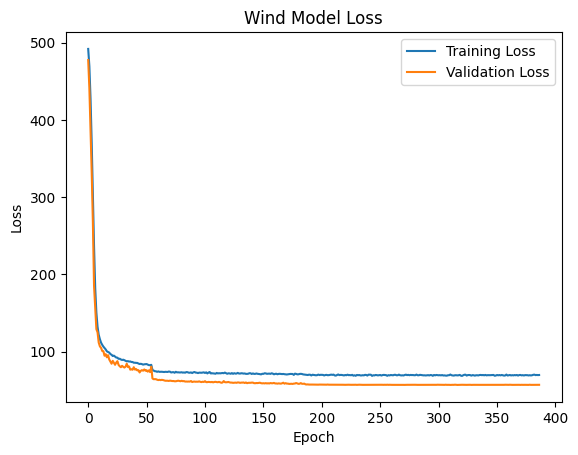

In [25]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Wind Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Make Preditions

In [26]:
import numpy as np

predictions = model.predict(X_test)
predictions[predictions < 0] = 0
flattened_predictions = [0 if (isinstance(pred, np.ndarray) and pred.item() < 0) else (0 if pred < 0 else pred.item() if isinstance(pred, np.ndarray) else pred) for pred in predictions]

print(f'Predicted Wind Energy Output: {flattened_predictions[:20]}')
print(f'Actual Wind Energy Output: {y_test[:20].values}')


449/449 [==============================] - 1s 1ms/step
Predicted Wind Energy Output: [270.92218017578125, 801.5866088867188, 35.77628707885742, 0.0, 697.5478515625, 325.6775207519531, 827.2647094726562, 347.9892883300781, 698.6513061523438, 810.5859985351562, 962.9354248046875, 522.0195922851562, 682.4852905273438, 298.2210388183594, 164.43685913085938, 3.9921677112579346, 520.5199584960938, 863.8390502929688, 122.21739959716797, 682.0744018554688]
Actual Wind Energy Output: [239. 810.  52.   7. 767. 140. 803. 365. 754. 872. 954. 459. 663. 229.
 168.   8. 793. 852. 114. 743.]


In [29]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# calc MAE
mae = mean_absolute_error(y_test, predictions)

# calc MSE
mse = mean_squared_error(y_test, predictions)

# calc RMSE
rmse = np.sqrt(mse)
average_y_test = np.mean(y_test)
percent_error = mae / average_y_test

# Display
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Percent Error (PERR): {percent_error}")

Mean Absolute Error (MAE): 57.24196034055738
Mean Squared Error (MSE): 12854.516574007079
Root Mean Squared Error (RMSE): 113.37776049123161
Percent Error (PERR): 0.11579742007175321


### Save Model

In [30]:
model.save('WindModel.h5')